Here we test how closely PyTorchDIA can recover the exact solution when known transformations have been applied to an image. Using Section 3.1 of Bramich 2008 as a guide, we explore the following:

(i) The data image is created by shifting the reference image by one pixel in each of the positive x and y spatial directions, without resampling. The corresponding kernel should be the identity kernel (central pixel value of 1 and 0 elsewhere) shifted by one pixel in each of the negative u and v kernel  coordinates.

(ii) The data image  has been  created by convolving the reference image with a gaussian of $\sigma_K$ = 1.5.

(iii) The reference image is shifted by half a pixel in each of the positive x and y spatial directions to create the data image, an operation that requires the resampling of the reference image. We use a bicubic spline resampling method (scipy.ndimage.interpolation.shift)

However, we'll start with a test '0', where no transformation has been applied; we simply difference an image against itself. ~~This is the only test for which we are truly testing the limiting numerical precision of our algorithm. Even if we shift a data image by just a single integer pixel, there is now no longer a one-to-one mapping for pixels at the borders perpendicular to the axis along which the shift was applied.~~

In [1]:
# imports
import numpy as np
# scipy.ndimage.interpolation.shift # for consistency with pyDANDIA!
from scipy.ndimage.interpolation import shift
# quote for manuscript - e.g. 'we are doing bicubic spline interpolation'
from scipy.signal import convolve2d
from astropy.io import fits
from MakeFakeImage import MakeFake
import time
import matplotlib.pyplot as plt
%matplotlib inline

In the cell below we'll generate a synthetic reference image. This uses the image generation procedure outlined in Section 3.1 of the manuscript, albeit for a single image. ~~Note however that the particular pyDANDIA implementation of this algorithm which we use in this work makes use of zero-padding so as to include all target image pixels into the kernel solution. This is at the expense of having a mathematically correct model image for the these boundary pixels, and so to guard against this systematic, we will generate a large 1000x1000 pixel image. Further, due to reasons motivating test '0' above, the larger image will further mitigate the effects due to lost information at the image borders.~~

Max flux: 31887.373306543665
Frac for 142x142 image: 0.3336664210470882
Reference properties
Reference size: 142
Number of sources: 26
PSF standard deviation: 2.4014286128198323
Sky level: 734.6740023932911
F_max/F_total: 0.3336664210470882


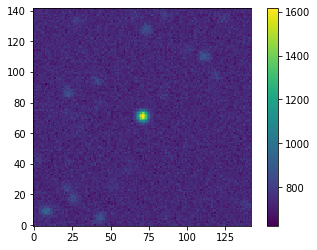

In [2]:
### generate a reference image
np.random.seed(42) # seed for reproducibility

size = 142
log_density = np.random.uniform(0, 3, 1)[0]
#print(log_density)
star_density = 10**log_density # stars per 100x100 pixels
n_sources = np.int(star_density * (size**2/100**2))

reference_psf_sigma = np.random.uniform(0.5, 2.5, 1)[0] # this is ~ [1 - 6] fwhm
sky = np.random.uniform(10, 1000, 1)[0]

# positions
# for convolution in test (ii), phi_I ~ sqrt(2.5**2 + 1.5**2) ~ 3 pixels i.e. 5 standard deviations border = 15 
border = 0
positions_x = np.random.uniform(border, size-border, (n_sources,1))
positions_y = np.random.uniform(border, size-border, (n_sources,1))
positions = np.hstack((positions_x, positions_y))

# fluxes
F = np.random.uniform(10**(-9), 10**(-4.5), n_sources)
fluxes = F**(-2./3.)
ref_clean, F_frac = MakeFake(N=1, size=size, n_sources=n_sources,
                             psf_sigma=reference_psf_sigma, sky=sky,
                             positions=positions, fluxes=fluxes, shifts=[0., 0.])

print('Reference properties')
print('Reference size:', size)
print('Number of sources:', n_sources)
print('PSF standard deviation:', reference_psf_sigma)
print('Sky level:', sky)
print('F_max/F_total:', F_frac)

# and add some noise
def add_noise_to_image(image, read_noise):
    noise_map = np.random.normal(0, 1, size=image.shape)
    sigma_I = np.sqrt(read_noise**2 + image)
    image += noise_map*sigma_I
    return image, sigma_I

R, sigma_R = add_noise_to_image(ref_clean, read_noise=5)

# and plot
plt.imshow(R, origin='lower')
plt.colorbar();

OK, now let's generate the 3 data images for tests (i)-(iii).
First let's do (i) and (iii)...
I'll inspect the transformations by-eye to make sure all's well.

In [3]:
R.dtype, ref_clean.dtype

(dtype('float64'), dtype('float64'))

In [4]:
# save a np.ndarray as .fits
def save_numpy_as_fits(numpy_array, filename):
    hdu = fits.PrimaryHDU(numpy_array)
    hdul = fits.HDUList([hdu])
    hdul.writeto(filename, overwrite=True)

save_numpy_as_fits(R, 'data0.fits')

In [5]:
# load R - the image generation procedure above takes a **long** time for 1kx1k images
R = fits.getdata('data0.fits', dtype=np.float64)
sky = 734.6740023932911
#sky = 10
print('Sky level:', sky)

Sky level: 734.6740023932911


In [6]:
# (i) integer shift
int_shift = (1, 1)
data1 = shift(R, int_shift, order=0, cval=sky, prefilter=False)
save_numpy_as_fits(data1, 'data1.fits')

# (iii) sub-pixel shift, bicubic spline resampling
float_shift = (0.5, 0.5)
data3 = shift(R, float_shift, order=3, cval=sky, prefilter=False)
save_numpy_as_fits(data3, 'data3.fits')

...and now define a gaussian kernel to convolve with R for test (ii)

~~*A note on handling edge pixels in convolutions*~~

~~Valid convolutions do not exist for target image pixels within a convolution kernel's half-width from the image edges. We have the choice to (i) just ignore them and work with valid convoltuions only, or (ii) apply some sort of padding to the image(s). In this work, when computing the model image with the inferred kernel and background term, we zero-pad the reference image before convolving with the kernel. (Perhaps?) Importantly, we have inferred the model parameters with a sky-subtracted reference image. In this instance, using zero-padding on this sky-subtracted image is a good choice; we are in effect padding with the new sky level, 0. If however the 'sky' level is not zero in the image to padded, zero-padding does not seem like the best choice. Instead, try using the non-zero sky level.~~

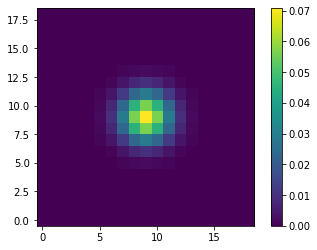

In [7]:
test_kernel_size = 19
nx, ny = (test_kernel_size, test_kernel_size) # kernel object shape
xg, yg = np.meshgrid(range(nx), range(ny))
xc, yc = (np.int(nx/2), np.int(ny/2))
sigma_k = 1.5 # gaussian kernel standard deviation
test_kernel = np.exp(-0.5 * ((xg - xc) ** 2 + (yg - yc) ** 2) / sigma_k ** 2)
test_kernel /= np.sum(test_kernel) # normalise to 1

# and plot
plt.imshow(test_kernel, origin='lower')
plt.colorbar();

# and convolve with the extended reference
#R_ext = extend_image_hw(R, test_kernel_size)
data2 = convolve2d(R, test_kernel, mode='same')
save_numpy_as_fits(data2, 'data2.fits')

Great, now let's run PyTorchDIA and pyDANDIA (B08) on the 3 image pairs. We'll need to first need to setup the Cythonized B08 solution.

In [8]:
%load_ext Cython

In [9]:
%%cython

## pyDANDIA functions consistent with no padding


from __future__ import division
import numpy as np
cimport numpy as np
cimport cython
DTYPE = np.float64
ctypedef np.float64_t DTYPE_t

# compile suggestion: gcc -shared -pthread -fPIC -fwrapv -O2 -Wall -fno-strict-aliasing -I/somepath/include/python2.7 -o umatrix_routine.so umatrix_routine.c

@cython.boundscheck(False) # turn off bounds-checking
@cython.wraparound(False)  # turn off negative index wrapping
@cython.nonecheck(False)  # turn off negative index wrapping

def umatrix_construction(np.ndarray[DTYPE_t, ndim = 2] reference_image,np.ndarray[DTYPE_t, ndim = 2] weights, pandq, n_kernel_np, kernel_size_np):

    cdef int ni_image = np.shape(reference_image)[0]
    cdef int nj_image = np.shape(reference_image)[1]
    cdef double sum_acc = 0.
    cdef int idx_l,idx_m,idx_l_prime,idx_m_prime,idx_i,idx_j
    cdef int kernel_size = np.int(kernel_size_np)
    cdef int kernel_size_half = np.int(kernel_size_np)/2
    cdef int n_kernel = np.int(n_kernel_np)
    cdef np.ndarray u_matrix = np.zeros([n_kernel + 1, n_kernel + 1], dtype=DTYPE)

    for idx_p in range(n_kernel):
        for idx_q in range(idx_p,n_kernel):
            sum_acc = 0.
            idx_l, idx_m = pandq[idx_p]
            idx_l_prime, idx_m_prime = pandq[idx_q]
            for idx_i in range(kernel_size_half, ni_image - kernel_size_half):
                for idx_j in range(kernel_size_half, nj_image - kernel_size_half):
                    sum_acc += reference_image[idx_i + idx_l, idx_j + idx_m] * reference_image[idx_i + idx_l_prime,idx_j + idx_m_prime]  * weights[idx_i, idx_j]
            u_matrix[idx_p, idx_q] = sum_acc
            u_matrix[idx_q, idx_p] = sum_acc

    for idx_p in [n_kernel]:
        for idx_q in range(n_kernel):
            sum_acc = 0.
            idx_l = kernel_size
            idx_m = kernel_size
            idx_l_prime, idx_m_prime = pandq[idx_q]
            for idx_i in range(kernel_size_half, ni_image - kernel_size_half):
                for idx_j in range(kernel_size_half, nj_image - kernel_size_half):
                    sum_acc += reference_image[idx_i + idx_l_prime, idx_j + idx_m_prime] * weights[idx_i, idx_j]
            u_matrix[idx_p, idx_q] = sum_acc
    
    for idx_p in range(n_kernel):
        for idx_q in [n_kernel]:
            sum_acc = 0.
            idx_l, idx_m = pandq[idx_p]
            idx_l_prime = kernel_size
            idl_m_prime = kernel_size
            for idx_i in range(kernel_size_half, ni_image - kernel_size_half):
                for idx_j in range(kernel_size_half, nj_image-kernel_size_half):
                    sum_acc += reference_image[idx_i + idx_l, idx_j + idx_m] * weights[idx_i, idx_j] 
            u_matrix[idx_p, idx_q] = sum_acc

    sum_acc = 0.
    for idx_i in range(kernel_size_half, ni_image - kernel_size_half):
        for idx_j in range(kernel_size_half, nj_image-kernel_size_half):
            sum_acc += weights[idx_i, idx_j] 
    u_matrix[n_kernel, n_kernel] = sum_acc
    
    return u_matrix

def bvector_construction(np.ndarray[DTYPE_t, ndim = 2] reference_image,np.ndarray[DTYPE_t, ndim = 2] data_image,np.ndarray[DTYPE_t, ndim = 2] weights, pandq, n_kernel_np, kernel_size_np):

    cdef int ni_image = np.shape(data_image)[0]
    cdef int nj_image = np.shape(data_image)[1]
    cdef double sum_acc = 0.
    cdef int idx_l,idx_m,idx_l_prime,idx_m_prime,idx_i,idx_j
    cdef int kernel_size = np.int(kernel_size_np)
    cdef int kernel_size_half = np.int(kernel_size_np)/2
    cdef int n_kernel = np.int(n_kernel_np)
        
    cdef np.ndarray b_vector = np.zeros([n_kernel + 1], dtype=DTYPE)
    for idx_p in range(n_kernel):
        idx_l, idx_m = pandq[idx_p]
        sum_acc = 0.
        for idx_i in range(kernel_size_half, ni_image - kernel_size_half):
            for idx_j in range(kernel_size_half,nj_image - kernel_size_half):
                   sum_acc += data_image[idx_i, idx_j] * reference_image[idx_i + idx_l , idx_j + idx_m ] * weights[idx_i, idx_j]
        b_vector[idx_p] = sum_acc

    sum_acc = 0.
    for idx_i in range(kernel_size_half, ni_image - kernel_size_half):
        for idx_j in range(kernel_size_half, nj_image - kernel_size_half):
            sum_acc += data_image[idx_i, idx_j] * weights[idx_i, idx_j]
    b_vector[n_kernel] = sum_acc

    return b_vector

In [10]:
import PyTorchDIA_noiseless_NoPad
import torch
torch.backends.cudnn.deterministic = True # ensure PyTorchDIA solution is reproducible

PyTorch version: 1.6.0


In [11]:
## Importantly, we'll subtract the known (scalar) sky level from the reference frame.
## This breaks the degeneracy between the photometric scale factor and the 
## differential background.

R0 = np.copy(R) # for test '0'

print('Sky level:', sky)
R -= sky

Sky level: 734.6740023932911


The B08 algorithm shoud be able to return the exact kernel solution, to within machine precision, given that this approach is analytical. Let's define some functions to run the required operations for this algorithm.

In [12]:
# define function to return the model image, and appropriately guard-against edge effects
def model_image(R, kernel, B0):
    model = convolve2d(R, kernel, mode='valid') + B0
    return model

# function to build the kernel, U matrix and b vector
def construct_kernel_and_matrices(kernel_size, R, I, weights):

    pandq = []
    n_kernel = kernel_size * kernel_size
    ncount = 0
    half_kernel_size = int(int(kernel_size) / 2)
    for lidx in range(kernel_size):
        for midx in range(kernel_size):
            pandq.append((lidx - half_kernel_size, midx - half_kernel_size))


    R = R.astype('float64')
    I =  I.astype('float64')
    weights = weights.astype('float64')
    

    start_time = time.time()
    U = umatrix_construction(R, weights, pandq, n_kernel, kernel_size)
    b = bvector_construction(R, I, weights, pandq, n_kernel, kernel_size)
    print("--- Finished U and b construction in %s seconds ---" % (time.time() - start_time))
    return U, b


# define a function for the least-squares solution
def lstsq_solution(R, I, U, b, kernel_size):
    
    lstsq_result = np.linalg.lstsq(np.array(U), np.array(b), rcond=None)
    a_vector = lstsq_result[0]
            
    lstsq_fit = np.dot(np.array(U), a_vector)
    resid = np.array(b) - lstsq_fit
    reduced_chisqr = np.sum(resid ** 2) / (float(kernel_size * kernel_size))
    lstsq_cov = np.dot(np.array(U).T, np.array(U)) * reduced_chisqr
    resivar = np.var(resid, ddof=0) * float(len(a_vector))
    
    # use pinv in order to stabilize calculation
    a_var = np.diag(np.linalg.pinv(lstsq_cov) * resivar)

    a_vector_err = np.sqrt(a_var)
    output_kernel = np.zeros(kernel_size * kernel_size, dtype=float)
    if len(a_vector) > kernel_size * kernel_size:
        output_kernel = a_vector[:-1]
    else:
        output_kernel = a_vector
    output_kernel = output_kernel.reshape((kernel_size, kernel_size))

    err_kernel = np.zeros(kernel_size * kernel_size, dtype=float)
    if len(a_vector) > kernel_size * kernel_size:
        err_kernel = a_vector_err[:-1]
        err_kernel = err_kernel.reshape((kernel_size, kernel_size))
    else:
        err_kernel = a_vector_err
        err_kernel = err_kernel.reshape((kernel_size, kernel_size))

    output_kernel_2 = np.flip(np.flip(output_kernel, 0), 1)
    err_kernel_2 = np.flip(np.flip(err_kernel, 0), 1)
    bkg_kernel = a_vector[-1]
    output_kernel_2.shape

    return output_kernel_2, bkg_kernel

def B08(R, I, flat, ks, sigma_0, n_iters):
    
    for i in range(0, n_iters):

        '''
        if i == 0:

            # for first pass, estimate weights with inverse variance map
            w = 1./(I + sigma_0**2)
        else:
            # replace I with current estimate of the model, M
            w = 1./(M + sigma_0**2)
        
        '''
        # for noiseless tests, every pixel has equal weight
        w = np.ones(I.shape)
        
        if i < n_iters:

            U, b = construct_kernel_and_matrices(ks, R, I, w)
            kernel, B0 = lstsq_solution(R, I, U, b, ks)
            
            print('P, B0:', np.sum(kernel), B0)
            
            M = convolve2d(R, kernel, mode='same') + B0
            
        if i == n_iters - 1:
            
            M = model_image(R, kernel, B0)

           
    return kernel, B0, M     

In [13]:
## check all image pairs have the correct shapes
R.shape, data1.shape, data2.shape, data3.shape

((142, 142), (142, 142), (142, 142), (142, 142))

In [14]:
# ...and the precision of the input data
# important for ascertaining numerical rounding errors
# F32: 6-9 decimal digit precision
# F64: 15-17 decimal digit precision
R.dtype, data1.dtype, data2.dtype, data3.dtype

(dtype('>f8'), dtype('float64'), dtype('float64'), dtype('float64'))

In [15]:
kernel_size = 19

In [16]:
124 ** 2, 361 * (124 ** 2)

(15376, 5550736)

## Test 0
Before moving on to tests (i)-(iii), let's do the test 0. Differencing R against itself. We should recover a kernel with a centre pixel of exactly 1 and zeros everywhere else.

In [17]:
kernel_b08_0, B0_b08_0, M_b08_0 = B08(R, R0, np.ones(R0.shape), kernel_size, 5, 1)

--- Finished U and b construction in 1.7812416553497314 seconds ---
P, B0: 1.0000000000003815 734.6740023932811


Photometric scale factor: 1.0000000000003815
Peak value of kernel: 0.9999999999999816
Differential Background: 734.6740023932811
Squared-sum of Difference image: 1.1041884794267377e-17


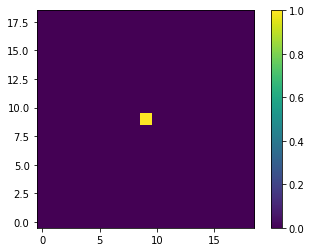

In [18]:
hwidth = np.int((kernel_size - 1) / 2)
nx, ny = R0.shape
R0_valid = R0[hwidth:nx-hwidth, hwidth:nx-hwidth] 

D_b08_0 = R0_valid - M_b08_0
plt.imshow(kernel_b08_0, origin='lower')
plt.colorbar();
print('Photometric scale factor:', np.sum(kernel_b08_0))
print('Peak value of kernel:', np.max(kernel_b08_0))
print('Differential Background:', B0_b08_0)
print('Squared-sum of Difference image:', np.sum(D_b08_0**2))

--- Time to move data onto GPU: 0.00026488304138183594 ---
Check dtype of data and weights:
torch.float32 torch.float32 torch.float32 torch.float32
Check size of data and weights:
torch.Size([1, 1, 142, 142]) torch.Size([1, 1, 124, 124]) torch.Size([1, 1, 19, 19]) torch.Size([1])
Starting optimisation
Switching to Quasi-Newton step after 196 SD steps
Converged!
Total steps taken: 205
SD steps: 196
L-BFGS steps: 9
--- Finished kernel and background fit in 0.873626708984375 seconds ---
Photometric scaling: tensor(0.9999995232, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 734.6740112304688


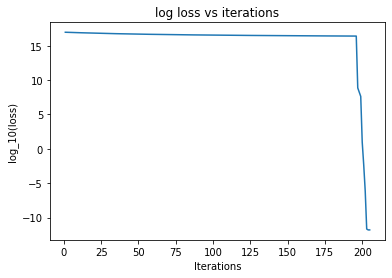

--- Finished in a total of 0.9985475540161133 seconds ---


In [30]:
# and now for PyTorchDIA

kernel_pt_0, B0_pt_0 = PyTorchDIA_noiseless_NoPad.DIA(R,
                           R0,
                           np.ones(R0.shape), # flatfield
                           rdnoise = 5,
                           G = 1,
                           ks = kernel_size,
                           lr_kernel = 1e-4,
                           lr_B = 1,
                           max_iterations = 25000,
                           poly_degree=0,
                           alpha = 0.,
                           Newton_tol = 1e-3,
                           tol = 1e-9,
                           fast=True,
                           fisher=False,
                           show_convergence_plots=True)

M_pt_0 = model_image(R, kernel_pt_0, B0_pt_0)

Photometric scale factor: 0.9999996
Peak value of kernel: 0.99999994
Photometric scale factor eror: -4.172325134277344e-07
Differential Background error: 1.2028706146541311e-08
Squared-sum of Difference image: 1.5778882509783723e-06


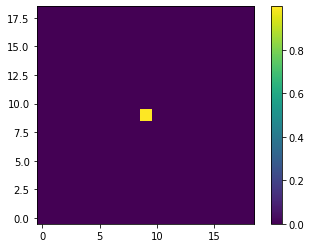

In [31]:
D_pt_0 = R0_valid - M_pt_0
plt.imshow(kernel_pt_0, origin='lower')
plt.colorbar();
print('Photometric scale factor:', np.sum(kernel_pt_0))
print('Peak value of kernel:', np.max(kernel_pt_0))
print('Photometric scale factor eror:', np.sum(kernel_pt_0) - 1)
print('Differential Background error:', (B0_pt_0 - sky) / sky)
print('Squared-sum of Difference image:', np.sum(D_pt_0**2))

In [21]:
print(np.sum(D_b08_0**2) / np.sum(D_pt_0**2))

6.99788770682641e-12


**Test '0' discussion**

## Test (i)

In [22]:
# OK, let's run B08 on the image pair for test (i)
kernel_b08_1, B0_b08_1, M_b08_1 = B08(R, data1, np.ones(data1.shape), kernel_size, 5, 1)

--- Finished U and b construction in 1.819383144378662 seconds ---
P, B0: 1.0000000000006308 734.674002393276


Photometric scale factor: 1.0000000000006308
epsilon P: 6.308287225920139e-13
Peak value of kernel: 0.9999999999999909
Differential Background: 734.674002393276
epsilon B_0: -2.0426287755340824e-14
Squared-sum of Difference image: 2.982833018416297e-17


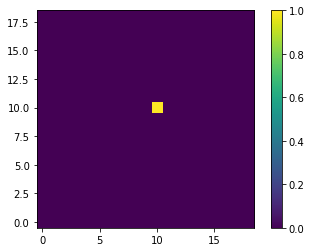

In [23]:
data1_valid = data1[hwidth:nx-hwidth, hwidth:nx-hwidth] 
D_b08_1 = data1_valid - M_b08_1
plt.imshow(kernel_b08_1, origin='lower')
plt.colorbar();
print('Photometric scale factor:', np.sum(kernel_b08_1))
print('epsilon P:', np.sum(kernel_b08_1) - 1)
print('Peak value of kernel:', np.max(kernel_b08_1))
print('Differential Background:', B0_b08_1)
print('epsilon B_0:', (B0_b08_1 - sky) / sky)
print('Squared-sum of Difference image:', np.sum(D_b08_1**2))

--- Time to move data onto GPU: 0.003200054168701172 ---
Check dtype of data and weights:
torch.float32 torch.float32 torch.float32 torch.float32
Check size of data and weights:
torch.Size([1, 1, 142, 142]) torch.Size([1, 1, 124, 124]) torch.Size([1, 1, 19, 19]) torch.Size([1])
Starting optimisation
Switching to Quasi-Newton step after 3203 SD steps
Converged!
Total steps taken: 3207
SD steps: 3203
L-BFGS steps: 4
--- Finished kernel and background fit in 3.617044687271118 seconds ---
Photometric scaling: tensor(0.9999995232, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 734.6740112304688


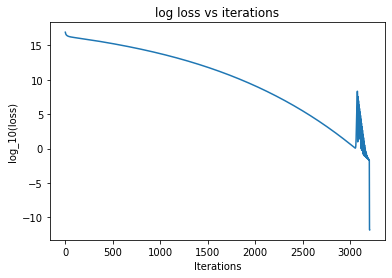

--- Finished in a total of 3.816011905670166 seconds ---


In [26]:
# and now for PyTorchDIA
kernel_pt_1, B0_pt_1 = PyTorchDIA_noiseless_NoPad.DIA(R,
                           data1,
                           np.ones(data1.shape), # flatfield
                           rdnoise = 5,
                           G = 1,
                           ks = 19,
                           lr_kernel = 1e-3,
                           lr_B = 1e-1,
                           max_iterations = 25000,
                           poly_degree=0,
                           alpha = 0.,
                           Newton_tol = 1e-3,
                           tol = 1e-9,
                           fast=True,
                           fisher=False,
                           show_convergence_plots=True)

M_pt_1 = model_image(R, kernel_pt_1, B0_pt_1)

Photometric scale factor: 0.9999996
Photometric scale factor error: -4.172325134277344e-07
Peak value of kernel: 1.0
Differential Background error: 1.2028706146541311e-08
epsilon B0: 1.2028706146541311e-08
Squared-sum of Difference image: 1.3568993405371758e-06


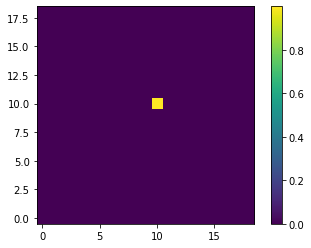

In [32]:
D_pt_1 = data1_valid - M_pt_1
plt.imshow(kernel_pt_1, origin='lower')
plt.colorbar();
print('Photometric scale factor:', np.sum(kernel_pt_1))
print('Photometric scale factor error:', np.sum(kernel_pt_1) - 1)
print('Peak value of kernel:', np.max(kernel_pt_1))
print('Differential Background error:', (B0_pt_1 - sky) / sky)
print('epsilon B0:', (B0_pt_1 - sky)/sky)
print('Squared-sum of Difference image:', np.sum(D_pt_1**2))

In [33]:
print(np.sum(D_b08_1**2) / np.sum(D_pt_1**2))

2.1982714040051333e-11


**Test (i) discussion**

## Test (ii)

In [35]:
# OK, let's run B08 on test (ii)
kernel_b08_2, B0_b08_2, M_b08_2 = B08(R, data2, np.ones(data2.shape), kernel_size, 5, 1)

--- Finished U and b construction in 1.7667014598846436 seconds ---
P, B0: 1.000000000000201 734.6740023932849


Photometric scale factor: 1.000000000000201
Peak value of kernel: 0.0707355302800568
Differential Background: 734.6740023932849
Squared-sum of Difference image: 1.981100013709657e-17


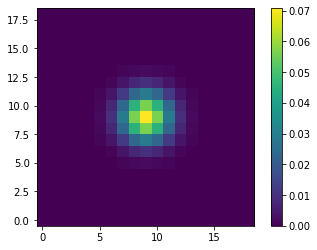

In [36]:
data2_valid = data2[hwidth:nx-hwidth, hwidth:nx-hwidth] 
D_b08_2 = data2_valid - M_b08_2
plt.imshow(kernel_b08_2, origin='lower')
plt.colorbar();
print('Photometric scale factor:', np.sum(kernel_b08_2))
print('Peak value of kernel:', np.max(kernel_b08_2))
print('Differential Background:', B0_b08_2)
print('Squared-sum of Difference image:', np.sum(D_b08_2**2))

--- Time to move data onto GPU: 0.0014109611511230469 ---
Check dtype of data and weights:
torch.float32 torch.float32 torch.float32 torch.float32
Check size of data and weights:
torch.Size([1, 1, 142, 142]) torch.Size([1, 1, 124, 124]) torch.Size([1, 1, 19, 19]) torch.Size([1])
Starting optimisation
Switching to Quasi-Newton step after 4613 SD steps
Converged!
Total steps taken: 4616
SD steps: 4613
L-BFGS steps: 3
--- Finished kernel and background fit in 6.069705486297607 seconds ---
Photometric scaling: tensor(0.9999997616, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 734.6740112304688


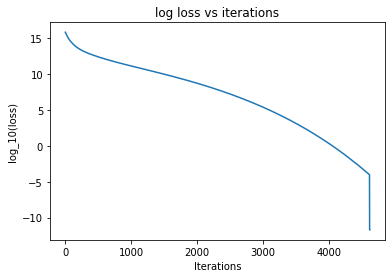

--- Finished in a total of 6.297842979431152 seconds ---


In [40]:
# test (ii)
kernel_pt_2, B0_pt_2 = PyTorchDIA_noiseless_NoPad.DIA(R,
                           data2,
                           np.ones(data2.shape), # flatfield
                           rdnoise = 5,
                           G = 1,
                           ks = 19,
                           lr_kernel = 1e-4,
                           lr_B = 1e-1,
                           max_iterations = 25000,
                           poly_degree=0,
                           alpha = 0.,
                           Newton_tol = 1e-3,
                           tol = 1e-9,
                           fast=True,
                           fisher=False,
                           show_convergence_plots=True)

M_pt_2 = model_image(R, kernel_pt_2, B0_pt_2)

Photometric scale factor: 0.9999997
Photometric scale factor error: -2.980232238769531e-07
Peak value of kernel: 0.07073552
Differential Background: 734.6740112304688
Differential Background error: 1.2028706146541311e-08
Squared-sum of Difference image: 1.4307977598308054e-06


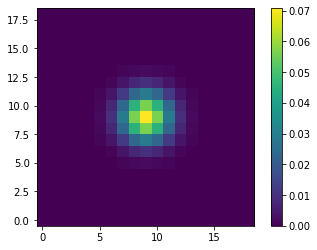

In [41]:
D_pt_2 = data2_valid - M_pt_2
plt.imshow(kernel_pt_2, origin='lower')
plt.colorbar();
print('Photometric scale factor:', np.sum(kernel_pt_2))
print('Photometric scale factor error:', np.sum(kernel_pt_2) - 1)
print('Peak value of kernel:', np.max(kernel_pt_2))
print('Differential Background:', B0_pt_2)
print('Differential Background error:', (B0_pt_2 - sky) / sky)
print('Squared-sum of Difference image:', np.sum(D_pt_2**2))

In [42]:
print(np.sum(D_b08_2**2)/np.sum(D_pt_2**2))

1.3846121858227718e-11


**Test (ii) discussion**

In [43]:
# OK, let's run B08 on test (iii)
kernel_b08_3, B0_b08_3, M_b08_3 = B08(R, data3, np.ones(data3.shape), kernel_size, 5, 1)

--- Finished U and b construction in 1.8031630516052246 seconds ---
P, B0: 1.0000000000002862 734.6740023932853


Photometric scale factor: 1.0000000000002862
epsilon P: 2.8621549574836536e-13
Peak value of kernel: 0.2296006944445201
Differential Background: 734.6740023932853
epsilon B_0: -7.8919748145635e-15
Squared-sum of Difference image: 1.9130750699097843e-17


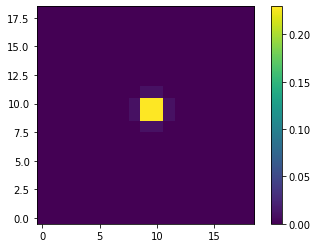

In [44]:
data3_valid = data3[hwidth:nx-hwidth, hwidth:nx-hwidth] 
D_b08_3 = data3_valid - M_b08_3
plt.imshow(kernel_b08_3, origin='lower')
plt.colorbar();
print('Photometric scale factor:', np.sum(kernel_b08_3))
print('epsilon P:', np.sum(kernel_b08_3) - 1)
print('Peak value of kernel:', np.max(kernel_b08_3))
print('Differential Background:', B0_b08_3)
print('epsilon B_0:', (B0_b08_3 - sky)/sky)
print('Squared-sum of Difference image:', np.sum(D_b08_3**2))

--- Time to move data onto GPU: 0.0010280609130859375 ---
Check dtype of data and weights:
torch.float32 torch.float32 torch.float32 torch.float32
Check size of data and weights:
torch.Size([1, 1, 142, 142]) torch.Size([1, 1, 124, 124]) torch.Size([1, 1, 19, 19]) torch.Size([1])
Starting optimisation
Switching to Quasi-Newton step after 1490 SD steps
Converged!
Total steps taken: 1492
SD steps: 1490
L-BFGS steps: 2
--- Finished kernel and background fit in 2.4321446418762207 seconds ---
Photometric scaling: tensor(0.9999996424, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 734.6740112304688


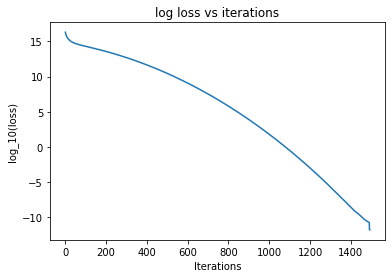

--- Finished in a total of 2.594444751739502 seconds ---


In [50]:
# test (iii)
kernel_pt_3, B0_pt_3 = PyTorchDIA_noiseless_NoPad.DIA(R,
                           data3,
                           np.ones(data3.shape), # flatfield
                           rdnoise = 5,
                           G = 1,
                           ks = kernel_size,
                           lr_kernel = 1e-3,
                           lr_B = 1e-1,
                           max_iterations = 25000,
                           poly_degree=0,
                           alpha = 0.,
                           Newton_tol = 1e-3,
                           tol = 1e-9,
                           fast=True,
                           fisher=False,
                           show_convergence_plots=True)


M_pt_3 = model_image(R, kernel_pt_3, B0_pt_3)

Photometric scale factor: 0.9999996
Photometric scale factor error: -4.172325134277344e-07
Peak value of kernel: 0.22960068
Differential Background error: 1.2028706146541311e-08
Squared-sum of Difference image: 1.2978549094086361e-06


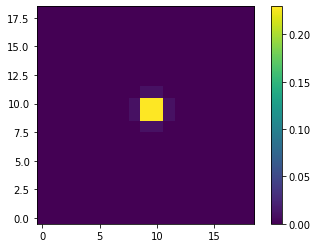

In [51]:
D_pt_3 = data3_valid - M_pt_3
plt.imshow(kernel_pt_3, origin='lower')
plt.colorbar();
print('Photometric scale factor:', np.sum(kernel_pt_3))
print('Photometric scale factor error:', np.sum(kernel_pt_3) - 1)
print('Peak value of kernel:', np.max(kernel_pt_3))
print('Differential Background error:', (B0_pt_3 - sky) / sky)
print('Squared-sum of Difference image:', np.sum(D_pt_3**2))

**Test (iii) discussion**


In [52]:
print(np.sum(D_b08_3**2)/np.sum(D_pt_3**2))

1.4740284572961022e-11
